## Проектная работа - Поиск путей развития бизнеса методом проверки гипотез А/B тестированием

### Описание проекта
Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга я подготовил список гипотез для увеличения выручки.
В этой работе я приоритизирую гипотезы, запущу A/B-тест и проанализирую его результаты.


### Описание данных

Данные для первой части проекта
Файл `/datasets/hypothesis.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/hypothesis.csv)

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части проекта
Файл `/datasets/orders.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders.csv)

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visitors.csv)

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста


### Загрузка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stats
import numpy as np
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings("ignore")

In [2]:
# импортируем данные
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
# посмотрим на исходные датафреймы
display(visitors)
display(orders)
hypothesis

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
# убираем заглавные буквы в названиях колонок
hypothesis.columns = hypothesis.columns.str.lower()

In [5]:
display(visitors.info())
display(orders.info())
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [6]:
# определяем количество дубликатов в каждом исходном датафрейме
print('Количество дубликатов в датафрейме visitors =', visitors.duplicated().sum())
print('Количество дубликатов в датафрейме orders =', orders.duplicated().sum())
print('Количество дубликатов в датафрейме hypothesis =', hypothesis.duplicated().sum())

Количество дубликатов в датафрейме visitors = 0
Количество дубликатов в датафрейме orders = 0
Количество дубликатов в датафрейме hypothesis = 0


Данные загрузились успешно. Пропусков нет, дубликатов нет, тип данных с датами надо будет заменить на соответствующий тип.

### Приоритизация гипотез.
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
Задача

    Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
    Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.
    Объяснить различия при их наличии.

In [7]:
# фреймворк ICE
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] * 1.0) / hypothesis['efforts']
pd.options.display.max_colwidth = 130
hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False)


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


In [8]:
# фреймворк RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] * 1.0) / hypothesis['efforts']
pd.options.display.max_colwidth = 130
hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


В обоих случаях 5-ка самых приоритетных гипотез состоит из гипотез: 

Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей 	

Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа

Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Запустить акцию, дающую скидку на товар в день рождения

Однако приоритеты различаются, так как второй метод учитывает и охват пользователей и вместо "Запустить акцию, дающую скидку на товар в день рождения" в лидеры выходит гипотеза под "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". В первой тройке в обоих методах присутствуют гипотезы:

Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### Анализ A/B-теста
A/B-тест были проведены и получены результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.
Задача
Проанализировать A/B-тест:

    Построить график кумулятивной выручки по группам и сделать выводы и предположения.
    Построить график кумулятивного среднего чека по группам и сделать выводы и предположения.
    Построить график относительного изменения кумулятивного среднего чека группы B к группе A и сделать выводы и предположения.
    Построить график кумулятивного среднего количества заказов на посетителя по группам и сделать выводы и предположения.
    Построить график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A и сделать выводы и предположения.
    Построить точечный график количества заказов по пользователям и сделать выводы и предположения.
    Посчитать 95-й и 99-й перцентили количества заказов на пользователя. Выбрать границу для определения аномальных пользователей.
    Построить точечный график стоимостей заказов и сделать выводы и предположения.
    Посчитать 95-й и 99-й перцентили стоимости заказов. Выбрать границу для определения аномальных заказов.
    Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным и сделать выводы и предположения.
    Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным и сделать выводы и предположения.
    Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным и сделать выводы и предположения.
    Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным и сделать выводы и предположения.
    Необходимо принять решение по результатам теста. Варианты решений:
    1. Остановить тест, зафиксировать победу одной из групп.
    2. Остановить тест, зафиксировать отсутствие различий между группами.
    3. Продолжить тест.

In [9]:
# изменение типа данных с датами на необходимый тип
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d')) 

In [10]:
# проверим, что группы А и В имеют уникальный набор покупателей
double_visitors = orders.pivot_table(index=['visitorId'], columns='group', values='revenue', aggfunc='count').reset_index()
double_visitors['dup_users'] = double_visitors['A'] + double_visitors['B']

In [11]:
# как видно из таблицы ниже, группы А и В не уникальны
duplicated_users = double_visitors.query('dup_users > 1').sort_values(by='dup_users', ascending=False)
duplicated_users

group,visitorId,A,B,dup_users
1023,4256040402,7.0,4.0,11.0
591,2458001652,5.0,6.0,11.0
569,2378935119,4.0,5.0,9.0
487,2038680547,5.0,3.0,8.0
299,1230306981,3.0,2.0,5.0
55,237748145,4.0,1.0,5.0
744,3062433592,1.0,4.0,5.0
44,199603092,4.0,1.0,5.0
897,3717692402,1.0,4.0,5.0
917,3803269165,1.0,4.0,5.0


In [12]:
# добавим в файл orders.csv столбец с признаком входит ли покупатель в обе группы или нет 
orders['is_dup'] = orders['visitorId'].isin(duplicated_users['visitorId'])

In [13]:
# посмотрим как по дням "неуникальные покупатели" совершали покупки 
dup_users_dates = orders.query('is_dup == True')
dup_users_dates_count = dup_users_dates.pivot_table(index=['date', 'visitorId'], columns='group', 
                                                    values='revenue', aggfunc='count').reset_index()
dup_users_dates_count.head(50)

group,date,visitorId,A,B
0,2019-08-01,8300375,NaN,1.0
1,2019-08-01,2716752286,NaN,1.0
2,2019-08-01,3062433592,NaN,2.0
3,2019-08-01,4256040402,1.0,NaN
4,2019-08-02,199603092,NaN,1.0
5,2019-08-02,2716752286,1.0,NaN
6,2019-08-03,1404934699,NaN,1.0
7,2019-08-03,3984495233,NaN,1.0
8,2019-08-04,2038680547,2.0,1.0
9,2019-08-04,2458001652,1.0,NaN


In [14]:
# определим как по днях распределено количество "неуникальных покупателей"
def cnt_user_fix(payment):
    if payment > 1:
        return 1
    else:
        return payment

dup_users_dates_count['A_extra'] = dup_users_dates_count['A'].apply(cnt_user_fix)
dup_users_dates_count['B_extra'] = dup_users_dates_count['B'].apply(cnt_user_fix)
extra_users = dup_users_dates_count.groupby('date').agg({'A_extra':'sum', 'B_extra':'sum'}).reset_index()
extra_users

,date,A_extra,B_extra
0,2019-08-01,1.0,3.0
1,2019-08-02,1.0,1.0
2,2019-08-03,0.0,2.0
3,2019-08-04,4.0,3.0
4,2019-08-05,3.0,2.0
5,2019-08-06,3.0,4.0
6,2019-08-07,2.0,1.0
7,2019-08-08,2.0,5.0
8,2019-08-09,3.0,5.0
9,2019-08-10,1.0,1.0


In [15]:
# приведем эту таблицу к виду файла с данными о количестве покупателей групп по дням: сначала идет группа А, под ней В.
extra_users_A = extra_users[['date', 'A_extra']]
extra_users_B = extra_users[['date', 'B_extra']]
extra_users_A.columns = ['date', 'visitors']
extra_users_B.columns = ['date', 'visitors'] 
total_dup = pd.concat([extra_users_A, extra_users_B], axis=0, join='outer', ignore_index=True, sort=None, copy=True)
display(total_dup.head(62))

,date,visitors
0,2019-08-01,1.0
1,2019-08-02,1.0
2,2019-08-03,0.0
3,2019-08-04,4.0
4,2019-08-05,3.0
...,...,...
57,2019-08-27,5.0
58,2019-08-28,5.0
59,2019-08-29,5.0
60,2019-08-30,3.0


In [16]:
# удаляем количество неуникальных покупателей из данных по количеству покупателей по дням
visitors['visitors'] = visitors['visitors'] - total_dup['visitors']
visitors

,date,group,visitors
0,2019-08-01,A,718.0
1,2019-08-02,A,618.0
2,2019-08-03,A,507.0
3,2019-08-04,A,713.0
4,2019-08-05,A,753.0
...,...,...,...
57,2019-08-27,B,715.0
58,2019-08-28,B,649.0
59,2019-08-29,B,526.0
60,2019-08-30,B,487.0


In [17]:
# удаляем данные неуникальных покупателей из данных о покупках.
orders = orders.query('is_dup == False')

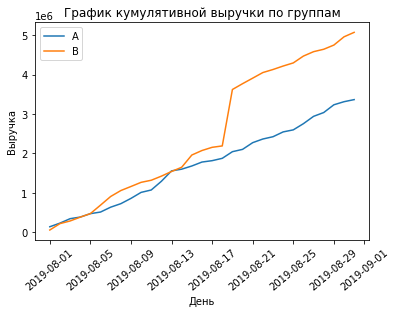

In [18]:
datesGroups = orders[['date','group']].drop_duplicates() 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == 
            x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 
                              'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == 
            x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

register_matplotlib_converters()
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.xlabel('День')
plt.ylabel('Выручка', rotation=90)
plt.xticks(rotation=40)
plt.legend();

Во второй половине теста группа B вырвалась вперёд и продолжала лидировать весь остаток теста. Увеличение выручки может быть связано как с увеличением количества заказов, так и с увеличением среднего чека, так и с обоими этими факторами. Возможно, что и аномально большие заказы могут влиять на результаты также. Вернемся к этому чуть позднее.

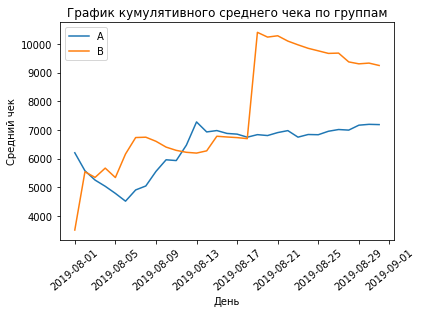

In [19]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('День')
plt.ylabel('Средний чек', rotation=90)
plt.xticks(rotation=40)
plt.legend();

С кумулятивным чеком та же картина: во второй половине теста группа B вырвалась вперёд и продолжала лидировать весь остаток теста. Возможно, что аномально большие заказы могут влиять на результаты. Вернемся к этому чуть позднее.

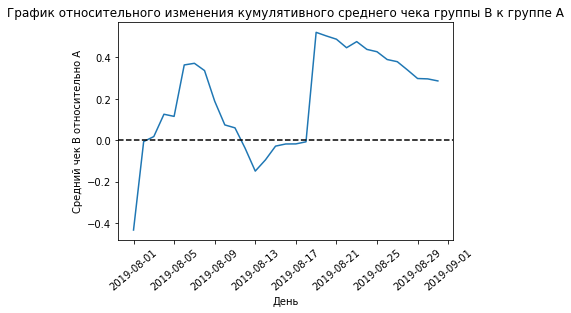

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', 
                                                   how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('День')
plt.ylabel('Средний чек B относительно А', rotation=90)
plt.xticks(rotation=40);

Результаты теста несколько раз менялись. Видимо, тогда могли быть совершены аномальные заказы.

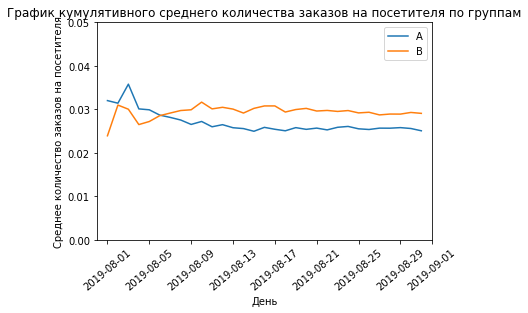

In [21]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('День')
plt.ylabel('Среднее количество заказов на посетителя', rotation=90)
plt.xticks(rotation=40);

# задаем масштаб осей
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), 0, 0.05]);

В начале теста группа A имела большее кумулятивное среднее количество заказов, но постепенно группа B выровнялась и зафиксировалась примерно около одного значения, больше значения группы A.

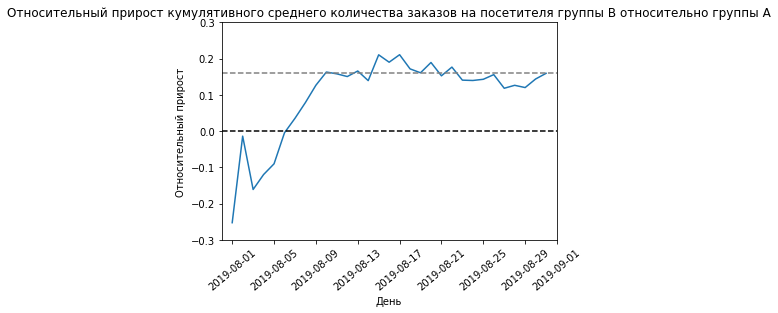

In [22]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1)

plt.title("Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
plt.xlabel('День')
plt.ylabel('Относительный прирост', rotation=90)
plt.xticks(rotation=40)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.16, color='grey', linestyle='--')
plt.axis(["2019-07-31", '2019-09-01', -0.3, 0.3]);

Почти с самого начала теста группа B лидирует по метрике: зафиксировалась около прироста в 16% относительно группы A

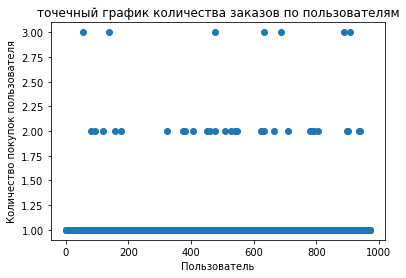

In [23]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title("точечный график количества заказов по пользователям")
plt.xlabel('Пользователь')
plt.ylabel('Количество покупок пользователя', rotation=90);

Пользователей, сделавших заказ больше 1 раза, совсем мало. Они вполне могут быть аномальными.

In [24]:
# Метод np.percentile('column', [percentile1, percentile2, percentile3]) находит перцентили.
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Не более 5% пользователей совершали больше 1 заказа. И не более 1% пользователей — больше 2 заказов. Аномальными можно считать покупателей, сделавших более 2 заказов.

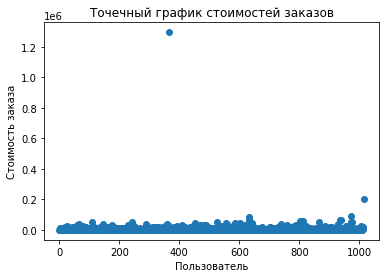

In [25]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title("Точечный график стоимостей заказов")
plt.xlabel('Пользователь')
plt.ylabel('Стоимость заказа', rotation=90);

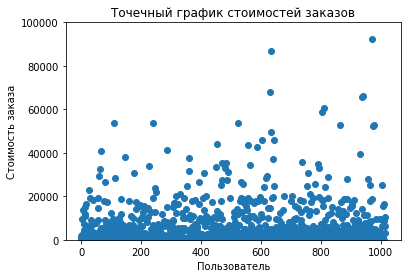

In [26]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 100000)
plt.title("Точечный график стоимостей заказов")
plt.xlabel('Пользователь')
plt.ylabel('Стоимость заказа', rotation=90);

Практически все заказы находятся в диапазоне от 0 до 100 000. Есть выбросы в районе 200 000 и в районе 1 300 000 рублей. Оба выглядят аномально большими.

In [27]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более, чем у 5% заказов чек дороже 26785. И не больше, чем у 1% заказов — дороже 53904. Будем считать аномальными заказы на сумму, превышающую 40000.

Сформулируем гипотезы: 

Нулевая: различий в среднем количестве заказов между группами нет. 

Альтернативная: различия в среднем между группами есть.

In [28]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - 
                                                                    len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - 
                                                                    len(ordersByUsersB['orders'])), name='orders')],axis=0)


print('p-value =', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))


print('относительное различие в среднем между группами =', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value = 0.01109
относительное различие в среднем между группами = 0.160


P-value меньше 0.05, потому нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет отвергаем. Анализ «сырых данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы B к конверсии группы A равен 16%.

Сформулируем гипотезы:

Нулевая: различий в среднем чеке между группами нет.

Альтернативная: различия в среднем чеке между группами есть.

In [29]:
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                       orders[orders['group']=='B']['revenue'])[1]))
print('относительное различие в среднем между группами =', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].\
                                                        mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value = 0.829
относительное различие в среднем между группами = 0.287


P-value больше 0.05 — статистически значимых отличий в среднем чеке между группами нет. Относительное различие среднего чека между группами составило 28.7%. Поскольку относительное различие среднего чека между сегментами составляет ~29%, наблюдаемые различия не являются значимыми при таком уровне значимости, а следовательно были получены случайно.

Сформулируем гипотезы: 

Нулевая: различий в среднем количестве заказов между группами нет. 

Альтернативная: различия в среднем между группами есть.

In [30]:
# получим очищенные данные, убрав из них покупателей, сделавших больше 2 заказов и заказы, стоимостью более 40000.

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], [95, 99])[1]]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], [95, 99])[1]]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > round(np.percentile(orders['revenue'], [95, 99]).mean(), -3)]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('p-value =', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('относительное различие в среднем между группами =', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.004
относительное различие в среднем между группами = 0.205


Как и в случае с сырыми данными, статистическая значимость достигнута. Группа B значительно лучше группы A.

Сформулируем гипотезы:

Нулевая: различий в среднем чеке между группами нет.

Альтернативная: различия в среднем чеке между группами есть.

In [31]:

print('p-value =',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)


print('относительное различие в среднем между группами =', 
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()/ orders[np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.937
относительное различие в среднем между группами = 0.055


Как и в случае с сырыми данными, статистически значимых отличий в среднем чеке между группами нет. После удаления аномалий средние чеки практически равны.

### Вывод

1) Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.

2) Нет статистически значимого различия по среднему чеку между группами. Относительное различие среднего чека между группами составило 28.7%, однако после удаления аномалий средние чеки обеих групп стали практически одинаковыми (разница около 1%).

3) График различия конверсии между группами говорит о том, что результаты группы B лучше группы A, которые зафиксировались около среднего значения.

Из приведенных выше результатов можно сделать вывод о том, что эксперимент прошел удачно и его можно завершить. Выручка группы В превышает показатели группы А, т.е. прибыль бизнеса будет больше за счет большего числа заказов если реализовать все проверенные А-В тестами гипотезы, несмотря на остуствие разницы в средних чеках.